In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

df = pd.read_csv(r'c:\Users\Gur Levy\Desktop\PORTFOLIO\DE_PORTFOLIO\forwards_data.csv')

data = pd.read_csv('combined_data.csv')
data = data[data['Player'] == 'E. Haaland']
actions = np.mean(data['Successful actions'])
shots = np.mean(data['Shots on target'])
dribbles = np.mean(data['Successful dribbles'])
off_duels = np.mean(data['Offensive duels won'])
touches_in_penalty_area = np.mean(data['Touches in penalty area'])
data['Goal_Scored'] = data['Goals'].apply(lambda x: 1 if x > 0 else 0)
data['actions_binary'] = data['Successful actions'].apply(lambda x: 1 if x >= actions else 0)
data['shots_binary'] = data['Shots on target'].apply(lambda x: 1 if x >= shots else 0)
data['dribbles_binary'] = data['Successful dribbles'].apply(lambda x: 1 if x >= dribbles else 0)
data['off_duels_binary'] = data['Offensive duels won'].apply(lambda x: 1 if x >= off_duels else 0)
data['touches_in_penalty_area'] = data['Touches in penalty area'].apply(lambda x: 1 if x >= touches_in_penalty_area else 0)

Y = data['Goal_Scored']
X = pd.DataFrame({
    'Successful actions': data['actions_binary'],
    'Successful shots': data['shots_binary'],
    'Successful dribbles': data['dribbles_binary'],
    'Offensive dules won': data['off_duels_binary'],
    'Touches in penalty area': data['touches_in_penalty_area']
})
# Drop missing values -- stacking here helps ensure the same misisn values are removed for both X and Y. 
YX = np.hstack((np.array(Y)[:, np.newaxis], X))
YX = YX[~np.any(np.isnan(YX), axis=1)]

# Define relevant design matrix (with associated names) and outcome to model
Y = YX[:,0]
X = pd.DataFrame(YX[:,1:], columns=['Successful_Actions', 'Successful_Shots', 'Successful_Dribbles', 'Offensive_Duels_Won', 'Touches_in_Penalty_Area'])  # Design matrix with column names
# Add 
X_with_intercept = sm.add_constant(X)

In [2]:
# Fit the model 
model = sm.Logit(Y, X_with_intercept['const']).fit()

Optimization terminated successfully.
         Current function value: 0.689892
         Iterations 3


In [3]:
# Get summary results
summary = model.summary()
print(summary)

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  248
Model:                          Logit   Df Residuals:                      247
Method:                           MLE   Df Model:                            0
Date:                Thu, 14 Nov 2024   Pseudo R-squ.:               4.813e-11
Time:                        08:02:43   Log-Likelihood:                -171.09
converged:                       True   LL-Null:                       -171.09
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1616      0.127     -1.269      0.205      -0.411       0.088


In [4]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

In [5]:
# Number of simulations
n_simulations = 1000

# Simulate beta coefficients:

# on the log-odds scale
simulated_base_log_odds = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

# on the odds scale
simulated_base_odds = np.exp(simulated_base_log_odds)

# on the probability scale
simulated_base_prob = logistic_sigmoid(simulated_base_log_odds)

# simulations array
simulated_base = np.stack((simulated_base_log_odds, simulated_base_odds, simulated_base_prob), axis=1)

In [6]:
print(simulated_base)

[[-0.23016709  0.79440085  0.44271092]
 [-0.37898964  0.6845527   0.40637061]
 [ 0.07543531  1.07835347  0.51884989]
 ...
 [-0.12919885  0.8787992   0.46774514]
 [-0.15515699  0.85628074  0.46128838]
 [-0.19657078  0.82154318  0.45101494]]


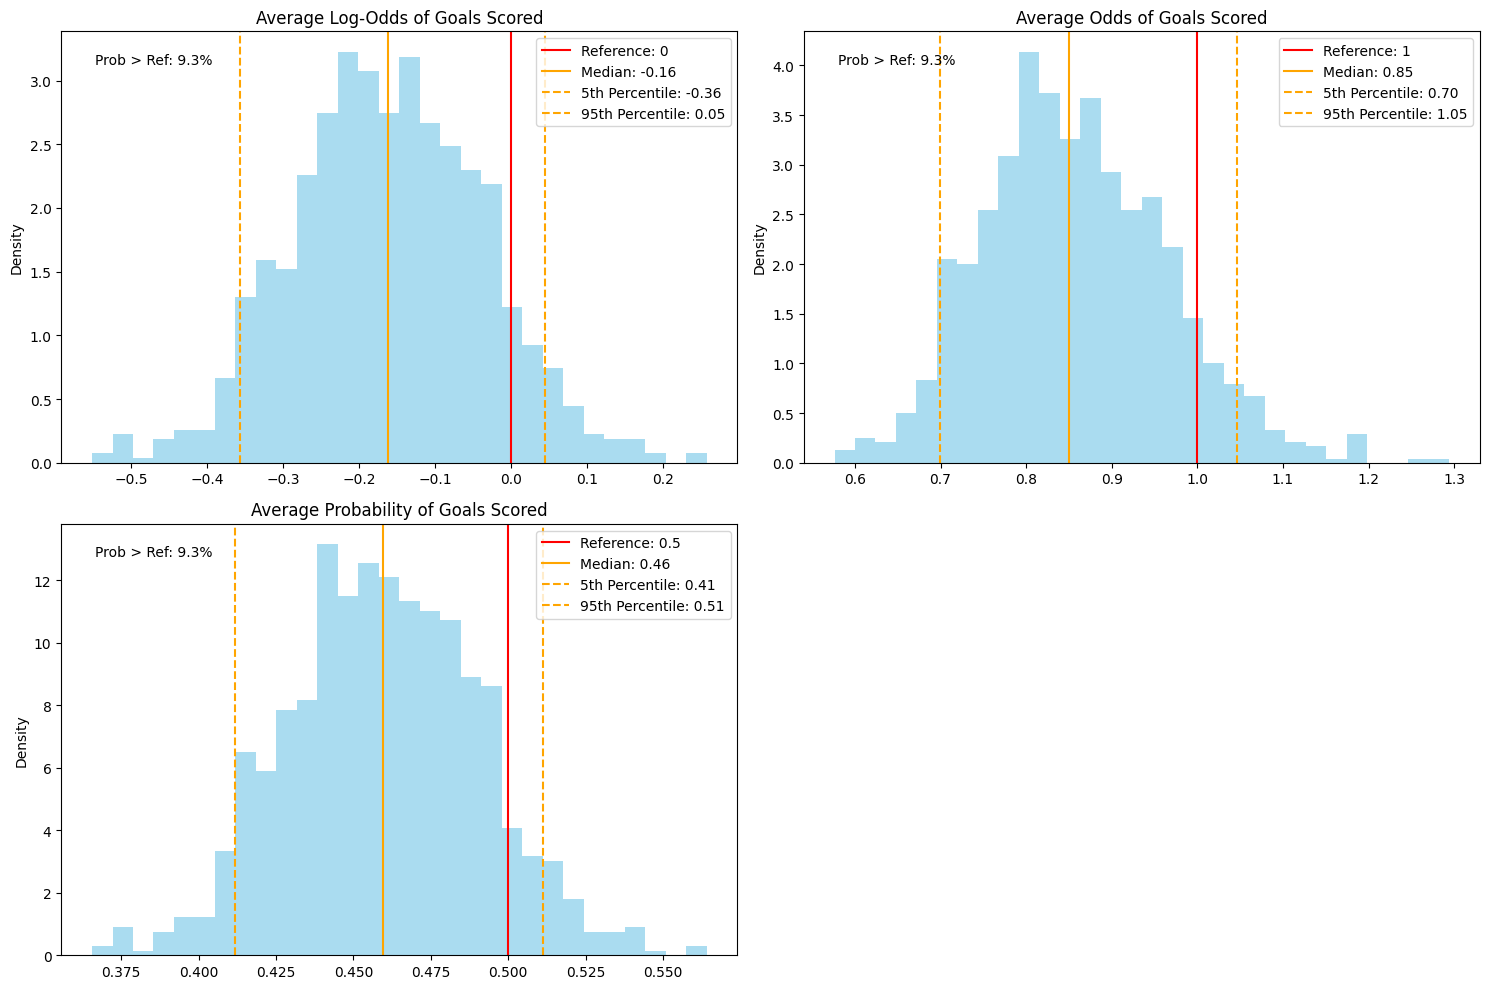

In [7]:
# Calculate statistics for each coefficient
medians = np.median(simulated_base, axis=0)
lower_quantiles = np.percentile(simulated_base, 5, axis=0)
upper_quantiles = np.percentile(simulated_base, 95, axis=0)
references = [0, 1, 0.5]  # Reference values for log-odds, odds, probability
prob_positive = [np.mean(simulated_base[:, i] > references[i]) for i in range(3)]

# Plot names 
col_names = ['Log-Odds', 'Odds', 'Probability']

# Plot histograms of each metric
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust for the number of metrics
axs = axs.flatten()

for i in range(len(col_names)):
    ax = axs[i]
    ax.hist(simulated_base[:, i], bins=30, density=True, alpha=0.7, color='skyblue')
    
    # Add vertical lines for reference, median, and 90% interval
    ax.axvline(references[i], color='red', linestyle='-', label=f'Reference: {references[i]}')
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    ax.text(0.05, 0.95, f'Prob > Ref: {prob_positive[i]*100:.1f}%', transform=ax.transAxes, verticalalignment='top')
    
    ax.set_title(f'Average {col_names[i]} of Goals Scored')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

# Hide empty subplot for uneven number of metrics
if len(col_names) % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

In [8]:
aic = model.aic
print("AIC:", aic)

AIC: 344.1863454770421


In [9]:
model = sm.Logit(Y, X_with_intercept[['const','Successful_Shots']]).fit()

Optimization terminated successfully.
         Current function value: 0.478136
         Iterations 6


In [10]:
# Get summary results
summary = model.summary()
print(summary)

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  248
Model:                          Logit   Df Residuals:                      246
Method:                           MLE   Df Model:                            1
Date:                Thu, 14 Nov 2024   Pseudo R-squ.:                  0.3069
Time:                        08:02:59   Log-Likelihood:                -118.58
converged:                       True   LL-Null:                       -171.09
Covariance Type:            nonrobust   LLR p-value:                 1.202e-24
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.3695      0.204     -6.698      0.000      -1.770      -0.969
Successful_Shots     3.0277      0.341      8.882      0.000       2.360       3.696


In [11]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

In [12]:
# Simulate values of each regression coefficient from the posterior distirbution 

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

In [13]:
# Derive odds from log-odds coefficients 
simulated_betas_odds = np.exp(simulated_betas)

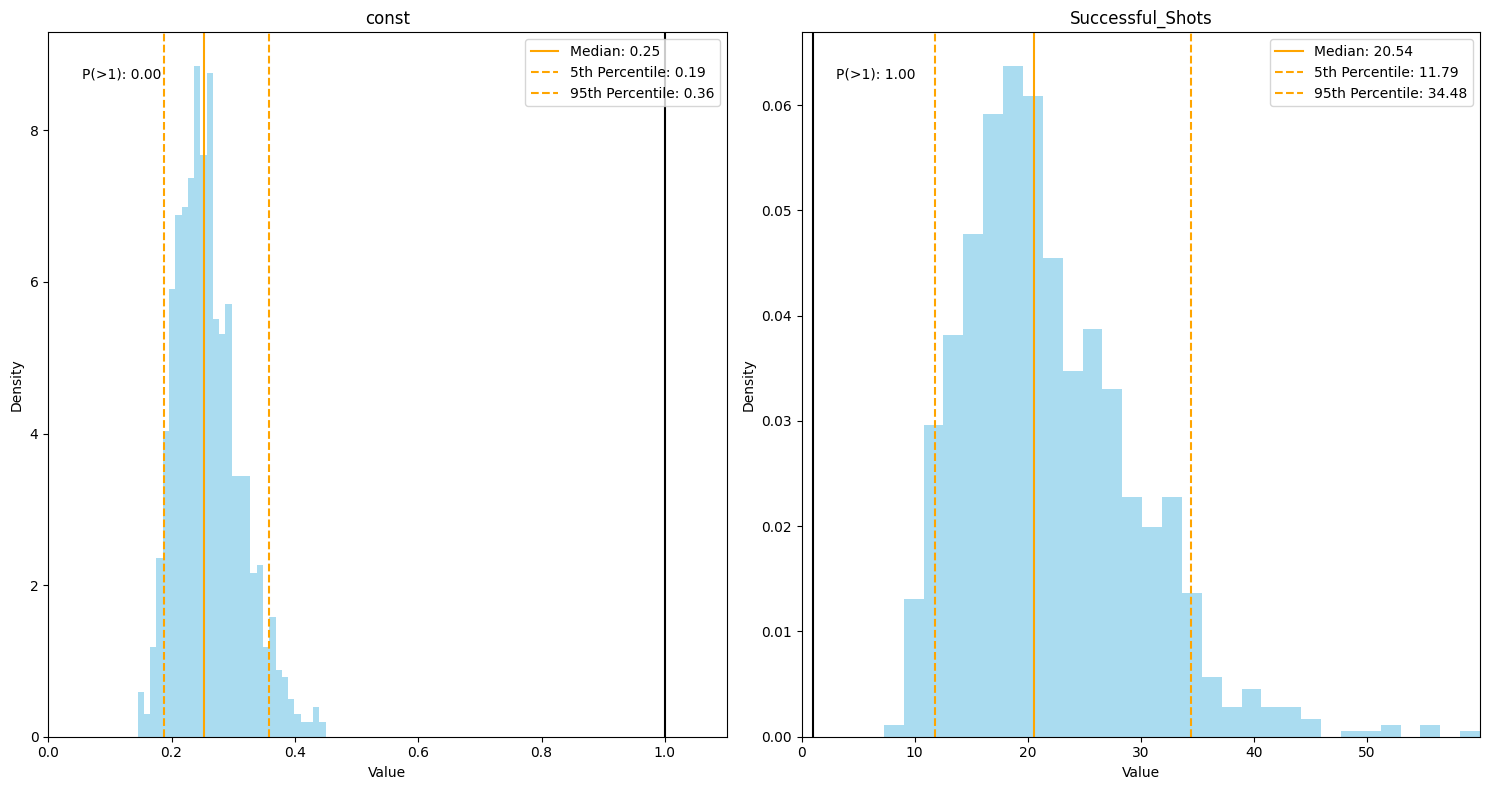

In [14]:
# Calculate statistics for each coefficient
medians = np.median(simulated_betas_odds, axis=0)
lower_quantiles = np.percentile(simulated_betas_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_betas_odds, 95, axis=0)
prob_positive = np.mean(simulated_betas_odds > 1, axis=0)

# Plot names 
col_names = ['const','Successful_Shots']

# Plot histograms of each coefficient
num_rows = (simulated_betas.shape[1] + 1) // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 8))
axs = axs.flatten()

for i in range(simulated_betas.shape[1]):
    ax = axs[i]
    ax.hist(simulated_betas_odds[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(1, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 1
    ax.text(0.05, 0.95, f'P(>1): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{ col_names[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 1 and starts at 0
    ax.set_xlim(left=0, right=max(1.1,abs(simulated_betas_odds[:, i]).max())) 
    
# Hide empty subplot
if simulated_betas.shape[1] % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

In [15]:
aic = model.aic
print("AIC:", aic)

AIC: 241.15539464082048
